In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler # Feature Scaling

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras.optimizers import Adam,SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM

%load_ext tensorboard

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. LSTM 작업
- time_step으로 배열 변경
- 입력될 데이터 배열 = (데이터 수, time_step, 데이터 칼럼 수)

In [19]:
lunch = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/lunch_df_encoding.csv")
dinner = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/dinner_df_encoding.csv")

In [20]:
lunch = lunch.dropna()
dinner = dinner.dropna()

In [21]:
lunch = lunch.drop(['datetime', 'year', 'month', 'date'], axis = 'columns')
dinner = dinner.drop(['datetime', 'year', 'month', 'date'], axis = 'columns')

In [22]:
#데이터 스케일링 
standard_scaler = StandardScaler()

#점심
lunch_fitted = standard_scaler.fit(lunch)

lunch_output = standard_scaler.transform(lunch)
lunch_output = pd.DataFrame(lunch_output, columns=lunch.columns, index=list(lunch.index.values))
print(lunch_output.head())

#저녁
dinner_fitted = standard_scaler.fit(dinner)

dinner_output = standard_scaler.transform(dinner)
dinner_output = pd.DataFrame(dinner_output, columns=dinner.columns, index=list(dinner.index.values))
print(dinner_output.head())

   worker_number  real_number  ...  new_lunch_N  new_lunch_Y
0      -1.206752     0.201002  ...     0.148627    -0.148627
1      -1.206752     0.070661  ...     0.148627    -0.148627
2      -1.206752    -0.003010  ...     0.148627    -0.148627
3      -1.206752    -0.501706  ...     0.148627    -0.148627
4      -1.206752    -1.266751  ...     0.148627    -0.148627

[5 rows x 27 columns]
   worker_number  real_number  ...  new_dinner_N  new_dinner_Y
0      -1.206752     0.201002  ...      0.133291     -0.133291
1      -1.206752     0.070661  ...      0.133291     -0.133291
2      -1.206752    -0.003010  ...      0.133291     -0.133291
3      -1.206752    -0.501706  ...      0.133291     -0.133291
4      -1.206752    -1.266751  ...      0.133291     -0.133291

[5 rows x 27 columns]


### 1. 점심 LSTM

In [23]:
# 점심 train/test size 설정
train_size = int(len(lunch_output)*0.6)
validation_size = int(len(lunch_output)*0.3)+train_size

#train/test 학습 및 라벨 설정
#종가를 예측하기 위해 종가를 label로 설정
train_x = np.array(lunch_output[:train_size])
train_y = np.array(lunch_output['lunch_number'][:train_size])

validation_x =np.array(lunch_output[train_size:validation_size])
validation_y = np.array(lunch_output['lunch_number'][train_size:validation_size])

test_x = np.array(lunch_output[validation_size:])
test_y = np.array(lunch_output['lunch_number'][validation_size:])

print(len(train_x))
print(len(validation_x))
print(len(test_x))
print(train_x.shape)
print(train_y.shape)

721
360
122
(721, 27)
(721,)


In [24]:
learning_rate = 0.01
training_cnt = 100
batch_size = 200
input_size = train_x.shape[1]

time_step = 1

# reshape into (size(개수), time step, 입력 feature)
train_x = train_x.reshape(train_x.shape[0],time_step,input_size)
validation_x = validation_x.reshape(validation_x.shape[0], time_step, input_size)
test_x = test_x.reshape(test_x.shape[0], time_step, input_size)
train_x.shape, test_x.shape

((721, 1, 27), (122, 1, 27))

In [25]:
# 모델 구조
model = Sequential()
model.add(LSTM(1024,input_shape=(1,input_size))) # 512는 다른 숫자로도 가능
model.add(Dropout(0.2)) 
model.add(Dense(1))

#오차 및 최적화기 설정
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['mae','mape'])
model.summary()


#학습
history = model.fit(train_x,train_y,epochs=training_cnt, batch_size=batch_size, verbose=1)
val_mse, val_mae, val_mape = model.evaluate(test_x, test_y, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1024)              4308992   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 4,310,017
Trainable params: 4,310,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 3s 137ms/step - loss: 0.5159 - mae: 0.5527 - mape: 256.7107
Epoch 2/100
4/4 [==============================] - 1s 133ms/step - loss: 0.1698 - mae: 0.3167 - mape: 166.7783
Epoch 3/100
4/4 [==============================] - 1s 136ms/step - loss: 0.1126 - mae:

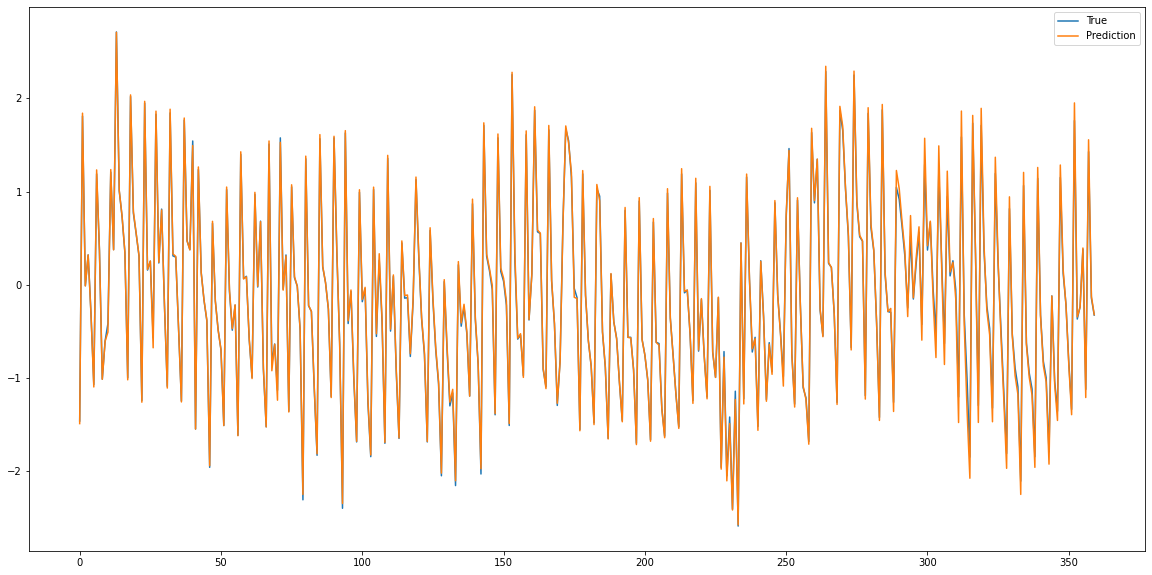

In [26]:
pred = model.predict(validation_x)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(validation_y, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

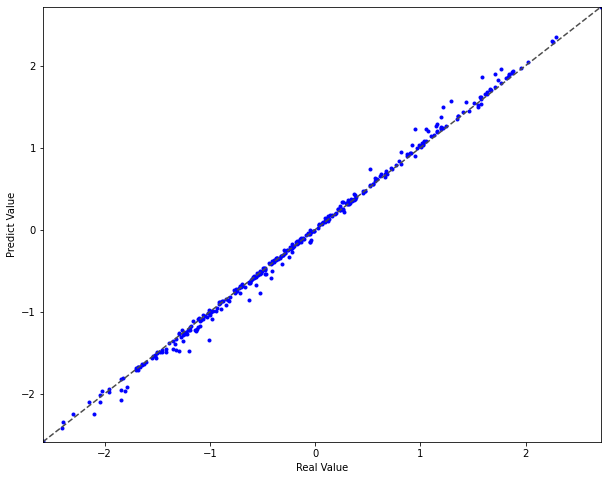

In [27]:
pred = model.predict(validation_x)

plt.figure(figsize=(10,8))
plt.plot(validation_y, pred, 'b.')

plt.axis([min(validation_y), max(validation_y), min(validation_y), max(validation_y)])

plt.plot([min(validation_y), max(validation_y)], [min(validation_y), max(validation_y)], ls = "--", c=".3")
plt.xlabel("Real Value")
plt.ylabel("Predict Value")

plt.show()

### 2. 저녁 LSTM

In [28]:
# 저녁 train/test size 설정
train_size = int(len(dinner_output)*0.6)
validation_size = int(len(dinner_output)*0.3)+train_size

#train/test 학습 및 라벨 설정
#종가를 예측하기 위해 종가를 label로 설정
train_x = np.array(dinner_output[:train_size])
train_y = np.array(dinner_output['dinner_number'][:train_size])

validation_x =np.array(dinner_output[train_size:validation_size])
validation_y = np.array(dinner_output['dinner_number'][train_size:validation_size])

test_x = np.array(dinner_output[validation_size:])
test_y = np.array(dinner_output['dinner_number'][validation_size:])

print(len(train_x))
print(len(validation_x))
print(len(test_x))
print(train_x.shape)
print(train_y.shape)

721
360
122
(721, 27)
(721,)


In [29]:
learning_rate = 0.01
training_cnt = 100
batch_size = 200
input_size = train_x.shape[1]

time_step = 1

# reshape into (size(개수), time step, 입력 feature)
train_x = train_x.reshape(train_x.shape[0],time_step,input_size)
validation_x = validation_x.reshape(validation_x.shape[0], time_step, input_size)
test_x = test_x.reshape(test_x.shape[0], time_step, input_size)
train_x.shape, test_x.shape

((721, 1, 27), (122, 1, 27))

In [30]:
# 모델 구조
model = Sequential()
model.add(LSTM(1024,input_shape=(1,input_size))) # 512는 다른 숫자로도 가능
model.add(Dropout(0.2)) 
model.add(Dense(1))

#오차 및 최적화기 설정
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['mae','mape'])
model.summary()


#학습
history = model.fit(train_x,train_y,epochs=training_cnt, batch_size=batch_size, verbose=1)
val_mse, val_mae, val_mape = model.evaluate(test_x, test_y, verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1024)              4308992   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 4,310,017
Trainable params: 4,310,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 3s 140ms/step - loss: 0.5654 - mae: 0.5231 - mape: 182.3123
Epoch 2/100
4/4 [==============================] - 1s 136ms/step - loss: 0.1924 - mae: 0.3365 - mape: 185.2437
Epoch 3/100
4/4 [==============================] - 1s 138ms/step - loss: 0.0764 - mae:

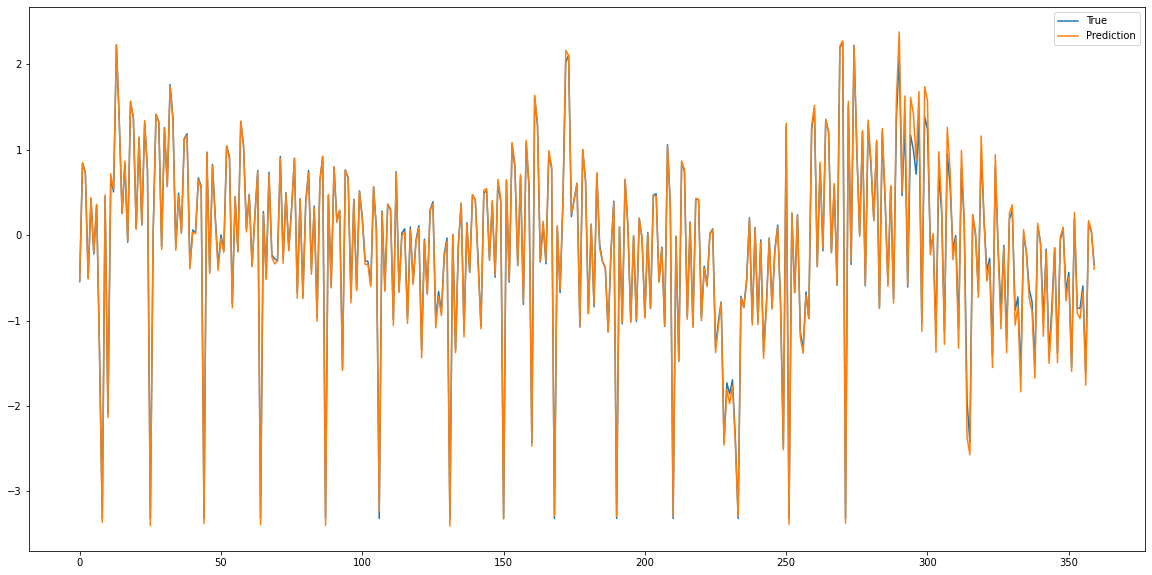

In [31]:
pred = model.predict(validation_x)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(validation_y, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

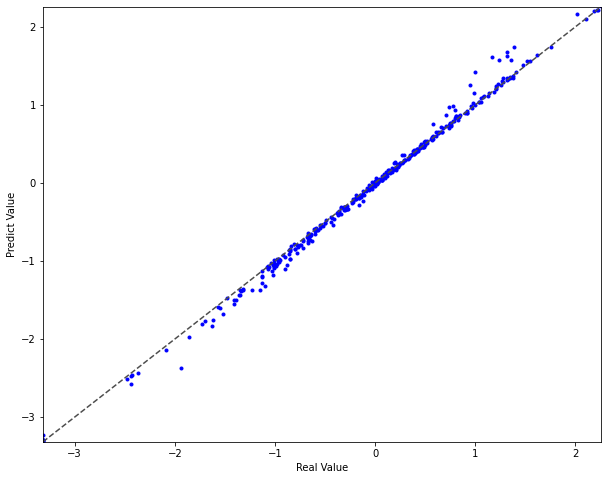

In [32]:
pred = model.predict(validation_x)

plt.figure(figsize=(10,8))
plt.plot(validation_y, pred, 'b.')

plt.axis([min(validation_y), max(validation_y), min(validation_y), max(validation_y)])

plt.plot([min(validation_y), max(validation_y)], [min(validation_y), max(validation_y)], ls = "--", c=".3")
plt.xlabel("Real Value")
plt.ylabel("Predict Value")

plt.show()